In [5]:
#Install/load required packages
!pip install dython | grep -v 'already satisfied'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


In [6]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [7]:
#Upload and record housing prices data 

train_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/cs231n_assignment/home-data-for-ml-course/train.csv', index_col='Id')
test_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/cs231n_assignment/home-data-for-ml-course/test.csv', index_col='Id')

### Data Summary

In [8]:
#Visualize the first entries of the dataset
train_data.head()
#test_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
#Brief summary of numerical columns
train_data.describe()
#test_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


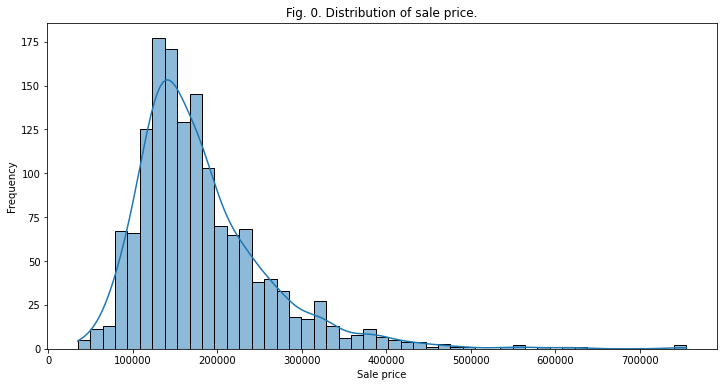

In [10]:
#Visualize the house sale price distribution
plt.figure(figsize=(12, 6))
plt.title('Fig. 0. Distribution of sale price.')
plt.xlabel('Sale price')
plt.ylabel('Frequency')
fig0 = sns.histplot(x=train_data.SalePrice, kde=True)


In [11]:
#Brief summary of categorical columns
train_data.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [12]:
#Identify columns with 'NaN' values and count the NaNs (train set)
train_data.isnull().sum()[train_data.isna().sum() != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [13]:
#Identify columns with 'NaN' values and count the NaNs (test set)
test_data.isna().sum()[test_data.isna().sum() != 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [14]:
#Train/test dataset columns with missing values (sorted in an ascending order of NA entries)
train_data_na_cols = train_data.isna().sum().sort_values()[train_data.isna().sum() != 0].index
test_data_na_cols = test_data.isna().sum().sort_values()[test_data.isna().sum() != 0].index

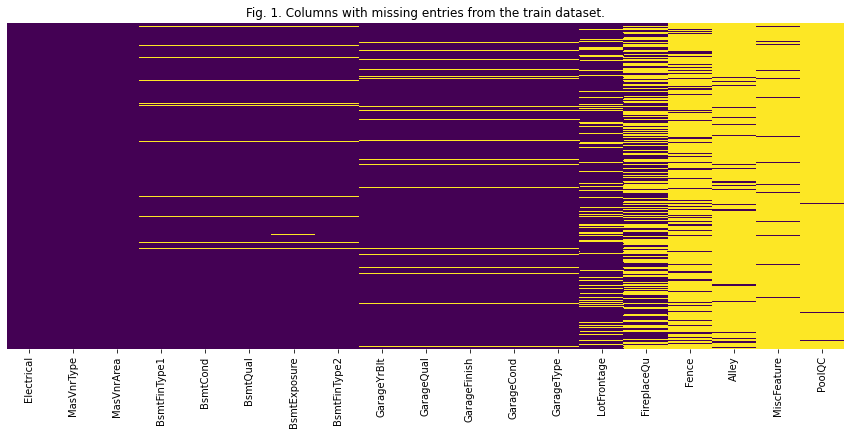

In [15]:
#Visualize missing entries in the train dataset  
plt.figure(figsize=(15,6))

fig1 = sns.heatmap(train_data.isna()[train_data_na_cols], yticklabels = False, 
                   cbar = False, cmap="viridis")
plt.ylabel('');
fig1.set(title = "Fig. 1. Columns with missing entries from the train dataset.");

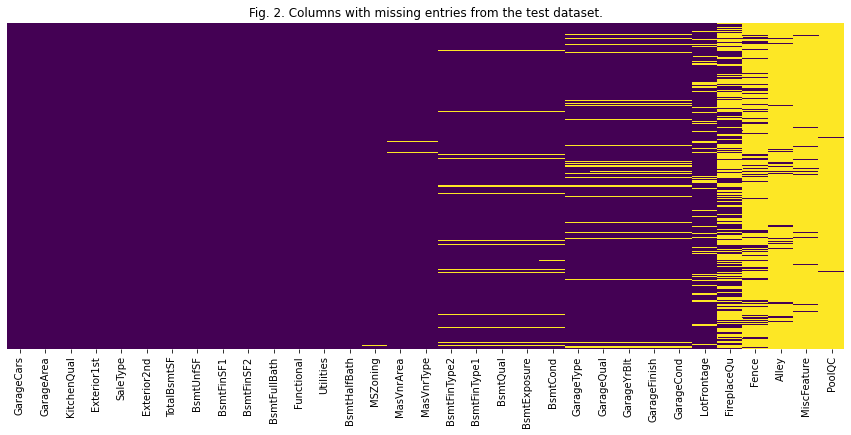

In [16]:
#Visualize missing entries in the test dataset  
plt.figure(figsize=(15,6))

fig2 = sns.heatmap(test_data.isna()[test_data_na_cols], yticklabels = False, 
                   cbar = False, cmap="viridis")
plt.ylabel('');
fig2.set(title = "Fig. 2. Columns with missing entries from the test dataset.");

We can see that there is a significant portion of missing values in both the training and testing datasets. However, as we will see later on, most of the missing values can be imputed in a clever way, meaning that the actual values can be deduced from the information provided in columns that don't contain missing entries.

### Supplemental lists of features
In this subsection we create supplemental lists of features that we will be using for a clever imputation of missing data.

In [17]:
num_cols = [col for col in train_data.columns if train_data[col].dtype in ['int64', 'float64']] #數字

#Numerical columns without 'SalePrice' and 'LotFrontage'
num_cols_no_SPLF = [col for col in num_cols if col not in ['SalePrice', 'LotFrontage']]

cat_cols = [col for col in train_data.columns if train_data[col].dtype == 'object'] #非數字

all_cols = cat_cols + num_cols #非數字和數字相加

#Print out the total number of columns to make sure that nothing is missing
print(f'The total number of columns: {len(all_cols)}.')
print(f'Expected number of columns: {train_data.shape[1]}.')

The total number of columns: 80.
Expected number of columns: 80.


In [18]:
#Create lists of garage-related numerical and categorical features  
gar_num_cols = ['GarageYrBlt','GarageCars','GarageArea']
gar_cat_cols = ['GarageType','GarageFinish','GarageQual','GarageCond']
gar_cols = gar_num_cols + gar_cat_cols

In [19]:
#Create lists of basement-related numerical and categorical features  
bsmt_num_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                 'TotalBsmtSF','BsmtFullBath','BsmtHalfBath']
bsmt_cat_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 
                 'BsmtFinType1', 'BsmtFinType2']
bsmt_cols = bsmt_num_cols + bsmt_cat_cols

### General assesment of correlations/associations 
Here, we will peform a general assesment of correlation/assosiation between the 'SalePrice' column and rest of the features. The 'SalePrice' is a numerical column, whereas the other 79 columns are either numerical or categorical. This means, we will need to analyze 2 different types of association/correlation: 1) a numerical-numerical correlation and 2) a categorical-numerical association.

To estimate the corresponding associations/correlations, we will use the dython library (see this link and this kaggle notebook for more examples). The dython library enables one to evaluate the following:

The `categorical-categorical` feature association (e.g. using the Theil's U measure).<br>
The `numerical-categorical` feature association (using the correlation ratio measure called Eta).<br>
The `numerical-numerical` correlation (using the Pearson's R measure).<br>

In [20]:
pip install dython

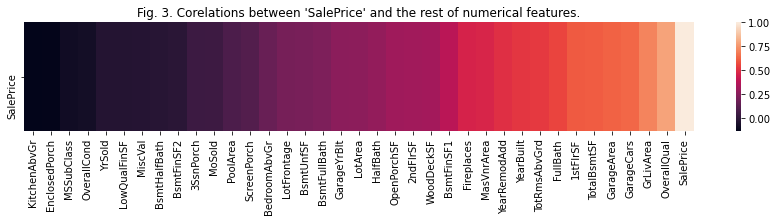

In [21]:
from dython.nominal import compute_associations

#Compute numerical-numerical correlations
num_corr_table = compute_associations(train_data[num_cols])

#Visualize correlations
plt.subplots(figsize=(15,2))
fig3 = sns.heatmap(num_corr_table[['SalePrice']].sort_values(by=['SalePrice']).T)
fig3.set(title = "Fig. 3. Corelations between 'SalePrice' and the rest of numerical features.");

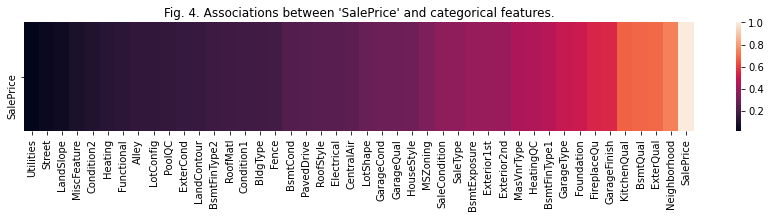

In [22]:
#Add 'SalePrice' to the list of categorical features for the data visualisation purposes
cat_cols.append('SalePrice')

#Compute numerical-categorical feature associations
numcat_assoc_table = compute_associations(train_data[cat_cols])

#Visualize associations
plt.subplots(figsize=(15,2))
fig4 = sns.heatmap(numcat_assoc_table[['SalePrice']].sort_values(by=['SalePrice']).T)
fig4.set(title = "Fig. 4. Associations between 'SalePrice' and categorical features.")

#Remove 'SalePrice' from the list of categorical features
cat_cols.pop();

We notice that most of the features that contain missing values in the train/test dataset have a strong degree of association/correlation with 'SalePrice'. This means that we should carefully impute the corresponding missing values, as they may have a significant impact on the predictions of our model.

## Data imputation
##### In order to better understand the data imputation strategy discussed below, one may need to look up occasionaly the "Data Description" information for the housing-prices dataset provided here.

### Basement-related features
We will start with imputing the basement-related features. First, we will visualize the corresponding data and notice that, for example, the hight of a basement ('BsmtQual') and its area ('TotalBsmtSF') have a strong association/correlation with the price of a house.



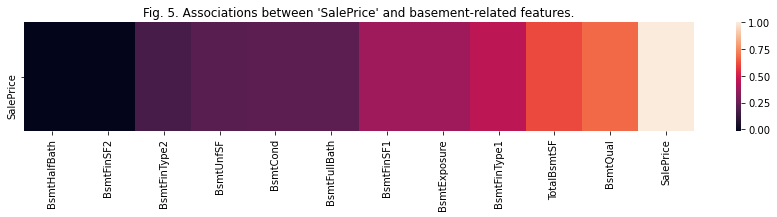

In [23]:
#Add 'SalePrice' to the list of basement-related features for the data visualisation purposes
bsmt_cols.append('SalePrice')

#Compute associations
bsmt_assoc_table = compute_associations(train_data[bsmt_cols])

#Visualize associations
plt.subplots(figsize=(15,2))
fig5 = sns.heatmap(bsmt_assoc_table[['SalePrice']].sort_values(by=['SalePrice']).T)
fig5.set(title = "Fig. 5. Associations between 'SalePrice' and basement-related features.");
bsmt_cols.pop();

In [24]:
#Before imputing the data, we create a copy of the train and test datasets
train_data_imp = train_data.copy() 
test_data_imp = test_data.copy()

In [25]:
#Locate the rows with a basement area = 0 (meaning there are no basements) 
#and replace the corresponding 'NaN' values of the garage categorical columns with 'NoBsmt'
train_data_imp.loc[train_data_imp['TotalBsmtSF'] == 0, bsmt_cat_cols] = \
train_data_imp.loc[train_data_imp['TotalBsmtSF'] == 0, bsmt_cat_cols].fillna(value = 'NoBsmt')

test_data_imp.loc[test_data_imp['TotalBsmtSF'] == 0, bsmt_cat_cols] = \
test_data_imp.loc[test_data_imp['TotalBsmtSF'] == 0, bsmt_cat_cols].fillna(value = 'NoBsmt')

In [26]:
#Count remaining 'NaN' values in the basement-related columns in the train set
train_data_imp[bsmt_cols].isna().sum()[train_data_imp[bsmt_cols].isna().sum() != 0]

BsmtExposure    1
BsmtFinType2    1
dtype: int64

In [27]:
#Count remaining 'NaN' values in the basement-related columns in the test set
test_data_imp[bsmt_cols].isna().sum()[test_data_imp[bsmt_cols].isna().sum() != 0]

BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
BsmtQual        3
BsmtCond        4
BsmtExposure    3
BsmtFinType1    1
BsmtFinType2    1
dtype: int64

One can see that most of the missing values in the basement-related features have been fixed.

### Garage-related features
In a similar fashion, we will fix most of the 'NaN' values in the garage-related columns.

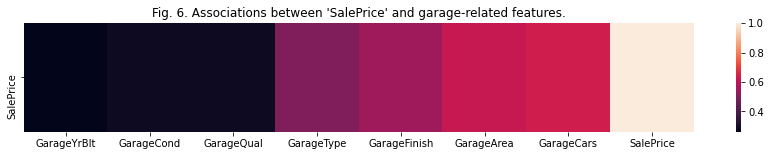

In [28]:
#Add 'SalePrice' to the list of garage-related features for the data visualisation purposes
gar_cols.append('SalePrice')

#Compute associations
gar_assoc_table = compute_associations(train_data[gar_cols])

#Visualize associations
plt.subplots(figsize=(15,2))
fig6 = sns.heatmap(gar_assoc_table[['SalePrice']].sort_values(by=['SalePrice']).T)
fig6.set(title = "Fig. 6. Associations between 'SalePrice' and garage-related features.");
gar_cols.pop();

In [29]:
#Locate the rows with a garage area = 0 (meaning there are no garages in such houses) 
#and replace the corresponding 'NaN' categorical values with 'NoGarage'
train_data_imp.loc[train_data_imp.GarageArea == 0, gar_cat_cols] = \
train_data_imp.loc[train_data_imp.GarageArea == 0, gar_cat_cols].fillna(value = 'NoGarage')

test_data_imp.loc[test_data_imp.GarageArea == 0, gar_cat_cols] = \
test_data_imp.loc[test_data_imp.GarageArea == 0, gar_cat_cols].fillna(value = 'NoGarage')

#When there is no garage, then replace the 'NaN' values in the 'GarageYrBlt' column with 0
train_data_imp.loc[train_data_imp.GarageArea == 0, 'GarageYrBlt'] = \
train_data_imp.loc[train_data_imp.GarageArea == 0, 'GarageYrBlt'].fillna(value = 0)

test_data_imp.loc[test_data_imp.GarageArea == 0, 'GarageYrBlt'] = \
test_data_imp.loc[test_data_imp.GarageArea == 0, 'GarageYrBlt'].fillna(value = 0)

In [30]:
#Count remaining 'NaN' values in the garage-related columns in the train set
train_data_imp[gar_cols].isna().sum()[train_data_imp[gar_cols].isna().sum() != 0]

Series([], dtype: int64)

In [31]:
#Count remaining 'NaN' values in the basement-related columns in the test set
test_data_imp[gar_cols].isna().sum()[test_data_imp[gar_cols].isna().sum() != 0]

GarageYrBlt     2
GarageCars      1
GarageArea      1
GarageFinish    2
GarageQual      2
GarageCond      2
dtype: int64

One can see that most of the missing values in the garage-related features have been fixed, as well.

## Fireplace-, pool-, miscellaneous-, fence-, and alley-related features
In this subsection we will impute the rest of the missing values whose values may be deduced from the information provided in columns that don't contain missing entries.
**在本小節中，我們將估算其餘的缺失值，其值可以從不包含缺失條目的列中提供的信息中推導出來。**

First, we will consider the fireplace-, pool-, and miscallaneous-related features. We notice that 'FireplaceQu', 'PoolQC', and 'MiscFeature' contain significant amount of missing values. These values can be imputed using the following strategy: when the number of fireplaces ('Fireplaces')/the pool area ('PoolArea')/the number of miscellaneous features ('MiscVal') equals to 0, then the corresponding 'NaN' values in the 'FireplaceQu'/'PoolQC'/'MiscFeature' column indicate that the corresponding house did not contain such a feature.


**(首先，我們將考慮與壁爐、游泳池和雜項相關的功能。我們注意到“FireplaceQu”、“PoolQC”和“MiscFeature”包含大量缺失值。可以使用以下策略來估算這些值：當壁爐數量 ('Fireplaces')/泳池面積 ('PoolArea')/雜項功能數量 ('MiscVal') 等於 0 時，則對應的 'NaN' 'FireplaceQu'/'PoolQC'/'MiscFeature' 列中的值表示相應的房子不包含這樣的特徵。)**

Since the imputation strategy for these 3 columns is identical, it is convenient to define a general function that will be performing such an imputation

In [32]:
def replace_na_values(check_column, nan_column, replace_value):
    train_data_imp.loc[(train_data_imp[nan_column].isna()) & 
                   (train_data_imp[check_column] == 0), nan_column] = replace_value
    test_data_imp.loc[(test_data_imp[nan_column].isna()) & 
                   (test_data_imp[check_column] == 0), nan_column] = replace_value

In [33]:
#Impute the fireplace-, pool-, and miscellaneous-related features
replace_na_values('Fireplaces', 'FireplaceQu', 'NoFireplace')
replace_na_values('PoolArea', 'PoolQC', 'NoPool')
replace_na_values('MiscVal', 'MiscFeature', 'NoMisc')

Now let's impute the missing values in 'Fence' and 'Alley' columns. The respective imputation strategy is even simpler than for the 'FireplaceQu'/'PoolQC'/'MiscFeature' columns. According to this description, the 'NaN' values in 'Fence' and 'Alley' columns are most likely due to the absence of the corresponding feature. Therefore, we will simply replace the coresponding NaNs by 'NoFence' or 'NoAlley'.

現在讓我們估算“Fence”和“Alley”列中的缺失值。相應的插補策略甚至比 'FireplaceQu'/'PoolQC'/'MiscFeature' 列更簡單。根據此描述，“Fence”和“Alley”列中的“NaN”值最有可能是由於缺少相應的特徵。因此，我們將簡單地用“NoFence”或“NoAlley”替換相應的 NaN。

In [34]:
#Replace NaN 'Fence' values
train_data_imp.loc[train_data_imp['Fence'].isna(), 'Fence'] = 'NoFence'
test_data_imp.loc[test_data_imp['Fence'].isna(), 'Fence'] = 'NoFence'

#Replace NaN 'Alley' values
train_data_imp.loc[train_data_imp['Alley'].isna(), 'Alley'] = 'NoAlley'
test_data_imp.loc[test_data_imp['Alley'].isna(), 'Alley'] = 'NoAlley'

## Rest of the features
At this stage, none of the remaining 'NaN' values can be imputed in a clever manner. Luckily, most of the remaning columns contain only a few 'NaN' entries. The only exception is the 'LotFrontage' column, which contains significant number of NaNs. By taking a look at Fig. 3 and checking the correlation between 'LotFrontage' and 'SalePrice', we notice that the 'LotFrontage' feature is not strongly correlated with the 'SalePrice'. In addition, by checking here the feature description information, we notice that most likely the 'LotArea' column (by default) contains information about 'LotFrontage'. Therefore, we decide to remove the 'LotFrontage' column from our model training/prediction


在這個階段，剩餘的“NaN”值都不能以巧妙的方式進行估算。幸運的是，大多數剩餘的列只包含幾個“NaN”條目。唯一的例外是“LotFrontage”列，其中包含大量 NaN。通過查看圖 3 並檢查“LotFrontage”和“SalePrice”之間的相關性，我們注意到“LotFrontage”特徵與“SalePrice”的相關性並不強。此外，通過在此處檢查特徵描述信息，我們注意到“LotArea”列（默認情況下）很可能包含有關“LotFrontage”的信息。因此，我們決定從我們的模型訓練/預測中刪除“LotFrontage”列

In [35]:
train_data_imp.drop(['LotFrontage'], axis=1, inplace=True)
test_data_imp.drop(['LotFrontage'], axis=1, inplace=True)

In [36]:
#Identify columns with 'NaN' values and count NaNs (train set)
train_data_imp.isna().sum()[train_data_imp.isna().sum() != 0]

MasVnrType      8
MasVnrArea      8
BsmtExposure    1
BsmtFinType2    1
Electrical      1
dtype: int64

In [37]:
test_data_imp.isna().sum()[test_data_imp.isna().sum() != 0]

MSZoning         4
Utilities        2
Exterior1st      1
Exterior2nd      1
MasVnrType      16
MasVnrArea      15
BsmtQual         3
BsmtCond         4
BsmtExposure     3
BsmtFinType1     1
BsmtFinSF1       1
BsmtFinType2     1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
KitchenQual      1
Functional       2
GarageYrBlt      2
GarageFinish     2
GarageCars       1
GarageArea       1
GarageQual       2
GarageCond       2
PoolQC           3
MiscFeature      1
SaleType         1
dtype: int64

In [38]:
#Train/test dataset columns with missing values (sorted in an ascending order of NA entries)
train_data_imp_na_cols = train_data_imp.isna().sum().sort_values()\
                         [train_data_imp.isna().sum() != 0].index
test_data_imp_na_cols = test_data_imp.isna().sum().sort_values()\
                        [test_data_imp.isna().sum() != 0].index

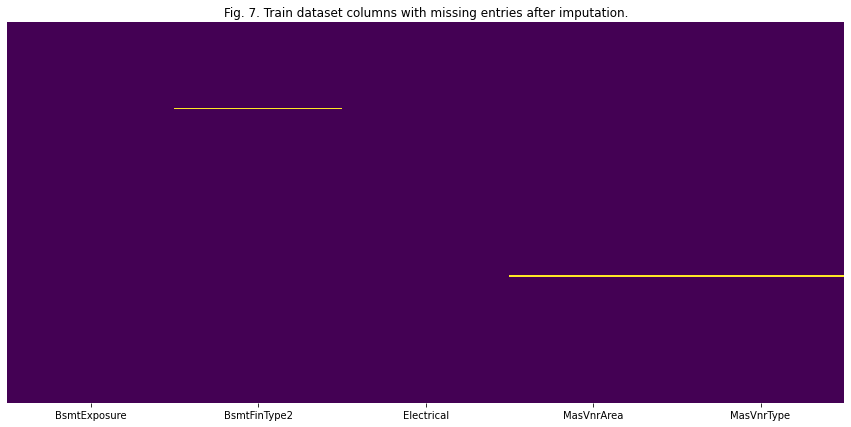

In [39]:
#Visualize missing entries in the train dataset after implementing the imputation  
plt.figure(figsize=(15,7))

fig7 = sns.heatmap(train_data_imp.isna()[train_data_imp_na_cols], yticklabels = False, 
                   cbar = False, cmap="viridis")
plt.ylabel('');
fig7.set(title = "Fig. 7. Train dataset columns with missing entries after imputation.");

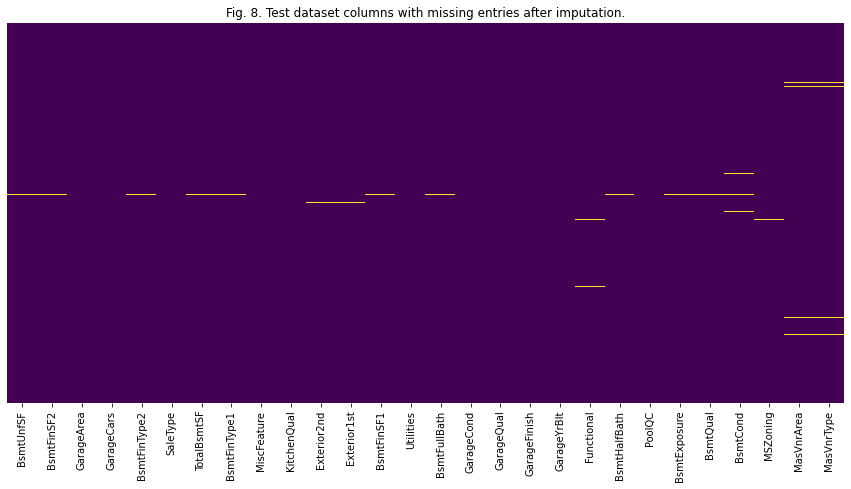

In [40]:
#Visualize missing entries in the test dataset after implementing the imputation  
plt.figure(figsize=(15,7))

fig8 = sns.heatmap(test_data_imp.isna()[test_data_imp_na_cols], yticklabels = False, 
                   cbar = False, cmap="viridis")
plt.ylabel('');
fig8.set(title = "Fig. 8. Test dataset columns with missing entries after imputation.");

Now we can see that all the remaining columns with 'NaN' values contain only a few NaNs, which can be safely imputed using one of the standard imputers.

### Preparation of ordinal categorical data for label encoding
In this section, we will prepare our categorical columns for model training/prediction. We note that our dataset contains 2 types of categorical columns:

* Ordinal (when the column has a clear ordering of categories)
* Nominal (when the column has no clear ordering of categories).<br>

We will use the ordinal encoding strategy for ordinal columns and the one-hot encoding strategy for nominal columns. Check out this and this Kaggle tutorials for more details.

The categories of ordinal data need to be properly ordered, so that the ordinal encoder assigns them proper numerical values. The corresponding values can be deduced from this data description information. For example, an entry in the 'LotShape' column can take the following values: Reg, IR1, IR2, or IR3. We want the ordinal encoder to assign them the values 3, 2, 1, 0, respectively (and not vice versa!!!).

Below we prepare our data for ordinal and one-hot encodings.

In [41]:
#Create a list of ordinal categorical features
cat_cols_ordinal = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 
                    'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure',
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir',
                    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'BsmtQual']

#Create a list of nominal categorical features
cat_cols_onehot = [x for x in cat_cols if x not in cat_cols_ordinal]

print(f'The number of ordinal categorical columns: {len(cat_cols_ordinal)}.')
print(f'The number of nominal categorical columns: {len(cat_cols_onehot)}.')
print(f'The total expected number of categorical columns: {len(cat_cols)}.')

The number of ordinal categorical columns: 21.
The number of nominal categorical columns: 22.
The total expected number of categorical columns: 43.


In [44]:
#Create a dictionary with ordinal categorical columns as keys 
#and corresponding categories as values
ordinal_cols_dict = {}
for col in cat_cols_ordinal:
    ordinal_cols_dict[col] = train_data_imp[col].unique().tolist()
ordinal_cols_dict

{'BsmtCond': ['TA', 'Gd', 'NoBsmt', 'Fa', 'Po'],
 'BsmtExposure': ['No', 'Gd', 'Mn', 'Av', 'NoBsmt', nan],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'NoBsmt', 'LwQ'],
 'BsmtFinType2': ['Unf', 'BLQ', 'NoBsmt', 'ALQ', 'Rec', 'LwQ', 'GLQ', nan],
 'BsmtQual': ['Gd', 'TA', 'Ex', 'NoBsmt', 'Fa'],
 'CentralAir': ['Y', 'N'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'FireplaceQu': ['NoFireplace', 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'Functional': ['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'],
 'GarageCond': ['TA', 'Fa', 'NoGarage', 'Gd', 'Po', 'Ex'],
 'GarageFinish': ['RFn', 'Unf', 'Fin', 'NoGarage'],
 'GarageQual': ['TA', 'Fa', 'Gd', 'NoGarage', 'Ex', 'Po'],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'KitchenQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'LandContour': ['Lvl', 'Bnk', 'Low', 'HLS'],
 'LandSlope': ['Gtl', 'Mod', 'Sev'],
 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
 'PavedDrive': ['Y', 'N', 'P'],
 'PoolQC': ['NoPool', 'Ex', 'Fa', '

Below, let us consider a small example which illustrates how the **OrdinalEncoder** transforms a dataset. This example emphasizes that a proper ordering of the ordinal categories is required in order to assign them meaningful numerical values.

In [49]:
from sklearn.preprocessing import OrdinalEncoder

ex_data = [['Reg'], ['IR2'], ['IR1'], ['IR3']]
#ex_data = np.asarray([['Reg'], ['IR2'], ['IR1'], ['IR3']])
print('Example dataset before ordinal encoding: \n', ex_data)
#encoder = OrdinalEncoder()
#encoder.fit_transform(X)

#ord_enc = OrdinalEncoder(categories=[['Reg', 'IR1', 'IR2', 'IR3']])
#encoder = OrdinalEncoder(categories=[["bad", "average", "good"]])
#encoder.fit_transform([["good"], ["bad"], ["bad"], ["average"]])

ord_enc = OrdinalEncoder(categories=[['Reg', 'IR1', 'IR2', 'IR3']])
ex_data_transformed = ord_enc.fit_transform(ex_data)
print('Example dataset after ordinal encoding (without proper ordering): \n', 
      ex_data_transformed)

Example dataset before ordinal encoding: 
 [['Reg'], ['IR2'], ['IR1'], ['IR3']]
Example dataset after ordinal encoding (without proper ordering): 
 [[0.]
 [2.]
 [1.]
 [3.]]


In [50]:
#Perform a proper orgering of the corresponding categories
ordinal_cols_dict['LotShape'] = ['IR3', 'IR2', 'IR1', 'Reg']
ordinal_cols_dict['LandContour'] = ['Low', 'HLS', 'Bnk', 'Lvl']
ordinal_cols_dict['Utilities'] = ['NoSeWa', 'AllPub']
ordinal_cols_dict['LandSlope'] = ['Sev', 'Mod', 'Gtl']
ordinal_cols_dict['ExterQual'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['ExterCond'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['BsmtCond'] = ['NoBsmt', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['BsmtExposure'] = ['NoBsmt', 'No', 'Mn', 'Av', 'Gd']
ordinal_cols_dict['BsmtFinType1'] = ['NoBsmt', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ordinal_cols_dict['BsmtFinType2'] = ['NoBsmt', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ordinal_cols_dict['HeatingQC'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['CentralAir'] = ['N', 'Y']
ordinal_cols_dict['KitchenQual'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['Functional'] = ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
ordinal_cols_dict['FireplaceQu'] = ['NoFireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['GarageFinish'] = ['NoGarage', 'Unf', 'RFn', 'Fin']
ordinal_cols_dict['GarageQual'] = ['NoGarage', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['GarageCond'] = ['NoGarage', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['PavedDrive'] = ['N', 'P', 'Y']
ordinal_cols_dict['PoolQC'] = ['NoPool','Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict['BsmtQual'] = ['NoBsmt', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_cols_dict

{'BsmtCond': ['NoBsmt', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtExposure': ['NoBsmt', 'No', 'Mn', 'Av', 'Gd'],
 'BsmtFinType1': ['NoBsmt', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'BsmtFinType2': ['NoBsmt', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'BsmtQual': ['NoBsmt', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'CentralAir': ['N', 'Y'],
 'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'FireplaceQu': ['NoFireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'Functional': ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 'GarageCond': ['NoGarage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageFinish': ['NoGarage', 'Unf', 'RFn', 'Fin'],
 'GarageQual': ['NoGarage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'LandContour': ['Low', 'HLS', 'Bnk', 'Lvl'],
 'LandSlope': ['Sev', 'Mod', 'Gtl'],
 'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
 'PavedDrive': ['N', 'P', 'Y'],
 'PoolQC': ['NoPool',

In [51]:
#Create a list of ordered ordinal categories suitable for model-training in the subsequent section
my_categories = list(ordinal_cols_dict.values())
my_categories

[['IR3', 'IR2', 'IR1', 'Reg'],
 ['Low', 'HLS', 'Bnk', 'Lvl'],
 ['NoSeWa', 'AllPub'],
 ['Sev', 'Mod', 'Gtl'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['NoBsmt', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['NoBsmt', 'No', 'Mn', 'Av', 'Gd'],
 ['NoBsmt', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['NoBsmt', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['N', 'Y'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 ['NoFireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['NoGarage', 'Unf', 'RFn', 'Fin'],
 ['NoGarage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['NoGarage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['N', 'P', 'Y'],
 ['NoPool', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['NoBsmt', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [52]:
#Train dataset that is ready for model training/prediction
y_train = train_data_imp.SalePrice
train_data_imp.drop(['SalePrice'], axis=1, inplace=True)
X_train_imp = train_data_imp.copy()

#Test dataset that is ready for model training/prediction
X_test_imp = test_data_imp.copy()


## Model training, selection, and predictions
### Data preprocessing
Before we train our model and make predictions, we will first preprocess our categorical and numerical columns using the ColumnTransformer class of the sklearn.compose module and prepare the data for fitting a machine learning model. (Check out this turotial to learn more about keeping your data preprocessing and modeling code organized)

在我們訓練模型並進行預測之前，我們將首先使用 sklearn.compose 模塊的 ColumnTransformer 類預處理我們的分類和數值列，並準備數據以擬合機器學習模型。 （查看此 turotial 以了解有關保持數據預處理和建模代碼井井有條的更多信息）

In [59]:
#Load required packages
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#Numerical and categorical columns transformation pipelines
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
])

cat_transformer_ordinal = Pipeline(steps=[
    ('cat_ord_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_transf', OrdinalEncoder(categories=my_categories))])
       ##handle_unknown='use_encoded_value', 
       ##unknown_value=np.nan))
##])

cat_transformer_onehot = Pipeline(steps=[
    ('cat_nom_imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_transf', OneHotEncoder(handle_unknown='ignore'))
])

#Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num_simple', num_transformer, num_cols_no_SPLF),
        ('cat_ordinal', cat_transformer_ordinal, cat_cols_ordinal),
        ('cat_onehot', cat_transformer_onehot, cat_cols_onehot)
])

### Model training
In this subsection, we will fit different machine learning algorithms with our preprocessed data and choose the optimal parameters for each model. We will consider the following models:

* Linear regression
* Decision tree regressor
* Random forest regressor
* Gradient boosting regressor
Linear regression

### Linear regression

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

model_LR = LinearRegression()

#Bundle preprocessing and modeling code in a pipeline
pipeline_LR = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('LR_model', model_LR)])

#MAE score using cross validation
scores = -1 * cross_val_score(pipeline_LR, X_train_imp, y_train,
                              cv=5, scoring='neg_mean_absolute_error')

print('MAE score for the Linear Regression:', np.mean(scores))

MAE score for the Linear Regression: 19928.77399855282


### Decision tree regressor

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

model_DTR = DecisionTreeRegressor()

#Bundle preprocessing and modeling code in a pipeline
pipeline_DTR = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('DTR_model', model_DTR)])

#Hyperparameter tuning implementation
param_grid_DTR = {
    'DTR_model__max_depth': [10, 20, 40], 
    'DTR_model__min_samples_leaf': [5, 10, 20], 
    'DTR_model__min_samples_split': [2, 5, 10],
    'DTR_model__random_state': [10],
}

searchCV_DTR = GridSearchCV(pipeline_DTR, param_grid=param_grid_DTR,
                            cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

searchCV_DTR.fit(X_train_imp, y_train)
print('Best parameters for the Decision Tree Regressor:')
for parameter in searchCV_DTR.best_params_:
    print (f'{parameter}: {searchCV_DTR.best_params_[parameter]}')
      
print('\nBest MAE score for the Decision Tree Regressor: ',
      searchCV_DTR.best_score_*(-1))

Best parameters for the Decision Tree Regressor:
DTR_model__max_depth: 20
DTR_model__min_samples_leaf: 10
DTR_model__min_samples_split: 2
DTR_model__random_state: 10

Best MAE score for the Decision Tree Regressor:  23758.09018205948


### Random forest regressor

In [62]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor()

#Bundle preprocessing and modeling code in a pipeline
pipeline_RFR = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('RFR_model', model_RFR)])

#Hyperparameter tuning implementation 超參數 調音 執行(嘗試出最好的參數)
param_grid_RFR = {
    'RFR_model__n_estimators': [80, 100], 
    'RFR_model__max_depth': [15, 30],
    'RFR_model__min_samples_split': [2, 5], 
    'RFR_model__random_state': [10],
}

searchCV_RFR = GridSearchCV(pipeline_RFR, param_grid=param_grid_RFR,
                            cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

searchCV_RFR.fit(X_train_imp, y_train)

print('Best parameters for the Random Forest Regressor:')
for parameter in searchCV_RFR.best_params_:
    print (f'{parameter}: {searchCV_RFR.best_params_[parameter]}')
    
print('\nBest MAE score for the Random Forest Regressor: ',
      searchCV_RFR.best_score_*(-1))

Best parameters for the Random Forest Regressor:
RFR_model__max_depth: 30
RFR_model__min_samples_split: 2
RFR_model__n_estimators: 80
RFR_model__random_state: 10

Best MAE score for the Random Forest Regressor:  17190.075368150683


### Gradient boosting regressor

In [63]:
from xgboost import XGBRegressor

model_XGBR = XGBRegressor()

#Bundle preprocessing and modeling code in a pipeline
pipeline_XGBR = Pipeline(steps=[('preprocessor', preprocessor),
                                ('XGBR_model', model_XGBR)])

#Hyperparameter tuning implementation
#To speed up this block, non-optimal parameters are commented out
param_grid = {
    'XGBR_model__n_estimators': [1500], #[1000, 1250, 1500]
    'XGBR_model__learning_rate': [0.07], #[0.07] [0.065, 0.07, 0.075],
    'XGBR_model__max_depth': [2], #[2,5,10]
    'XGBR_model__reg_alpha': [1], #[0, 0.5, 1, 5]
    'XGBR_model__reg_lambda': [0.01], #[0, 0.05, 0.1, 1]
    'XGBR_model__subsample': [0.95], #[0.5, 0.75, 0.9]
    'XGBR_model__colsample_bytree': [0.5]
}

searchCV_XGBR = GridSearchCV(pipeline_XGBR, param_grid=param_grid,
                             cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

searchCV_XGBR.fit(X_train_imp, y_train)
print('Best parameters for the XGBoosting Regressor:')
for parameter in searchCV_XGBR.best_params_:
    print (f'{parameter}: {searchCV_XGBR.best_params_[parameter]}')
    
print('Best MAE score for the XGBoosting Regressor:',
      searchCV_XGBR.best_score_*(-1))

[08:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters for the XGBoosting Regressor:
XGBR_model__colsample_bytree: 0.5
XGBR_model__learning_rate: 0.07
XGBR_model__max_depth: 2
XGBR_model__n_estimators: 1500
XGBR_model__reg_alpha: 1
XGBR_model__reg_lambda: 0.01
XGBR_model__subsample: 0.95
Best MAE score for the XGBoosting Regressor: 14826.893014233734


### Model selection and predictions

After testing four different regression models on cross validation data, we provide below a table that provides a summarizy of the mean absolute error scores achieved by these models. It is clear that the XGBoosting regressor performs the best on the cross validation data, and thus it will be employed for generating predictions for the test dataset.



---


In [64]:
pipeline_final = searchCV_XGBR.best_estimator_
predictions = pipeline_final.predict(X_test_imp)

### Submission
Finally, we prepare our predictions for a submition to the Housing Prices Competition for Kaggle Learn Users. 🥳

In [65]:
#Generate output
output = pd.DataFrame({'Id': X_test_imp.index, 
                       'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
